In [1]:
# Standard libraries
import pandas as pd
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os

# Enable auto-reload for module reloading during development
%load_ext autoreload
%autoreload 2

# Set display options for Pandas to show all columns
pd.set_option('display.max_columns', None)

# Load custom scripts
import data_check as ch

In [2]:
# Define the directory name for saving images
OUTPUT_DIR = "images"

# Check if the directory exists, if not, create it
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
products = pd.read_csv('amz_uk_price_prediction_dataset.csv')

In [4]:
products.head(5)

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


In [5]:
ch.check(products)

Number of columns: 9 and rows: 2443651

Data types:
uid                    int64
asin                  object
title                 object
stars                float64
reviews                int64
price                float64
isBestSeller            bool
boughtInLastMonth      int64
category              object
dtype: object

Unique values count:
uid                  2443651
asin                 2222742
title                2077591
stars                     42
reviews                19446
price                  82916
isBestSeller               2
boughtInLastMonth         25
category                 296
dtype: int64

These columns appear to be categorical (less than 20 unique values):
Index(['isBestSeller'], dtype='object')

Unique value count for categorical columns:

isBestSeller:
isBestSeller
False    2435671
True        7980
Name: count, dtype: int64

Count of null values:
uid                  0
asin                 0
title                0
stars                0
reviews            

# Part 1: Analyzing Best-Seller Trends Across Product Categories

### 1. Crosstab Analysis:

In [6]:
crosstab = pd.crosstab(products['category'], products['isBestSeller'], normalize='index')
crosstab

isBestSeller,False,True
category,,
3D Printers,0.995968,0.004032
3D Printing & Scanning,0.999508,0.000492
Abrasive & Finishing Products,0.980000,0.020000
Action Cameras,0.999411,0.000589
Adapters,0.988189,0.011811
...,...,...
Wind Instruments,0.972000,0.028000
Window Treatments,0.979079,0.020921
Women,0.988015,0.011985


In [7]:
crosstab_sorted = pd.DataFrame(crosstab[True].sort_values(ascending=False))
crosstab_sorted.head(5)

,True
category,
Grocery,0.058135
Smart Home Security & Lighting,0.057692
Health & Personal Care,0.057686
Mobile Phone Accessories,0.042471
Power & Hand Tools,0.035339


### 2. Statistical Tests:

In [8]:
chi2, p, dof, expected = chi2_contingency(crosstab)
print(f"\nChi-square Test Results: Chi2 = {chi2}, p-value = {p}")
if p < 0.05:
    print("There is a significant association between the categorical variables")
else:
    print("There is not enough evidence to conclude a significant association between the variables")


Chi-square Test Results: Chi2 = 3.9130707743346096, p-value = 1.0
There is not enough evidence to conclude a significant association between the variables


In [9]:
crosstab_result = pd.crosstab(products['category'], products['isBestSeller'])
cramers_v = association(crosstab_result, method='cramer')
print(f"Cramér's V: {cramers_v}")
print(f"The Cramer value of {cramers_v} suggests a weak association between two variables.")

Cramér's V: 0.1222829439760564
The Cramer value of 0.1222829439760564 suggests a weak association between two variables.


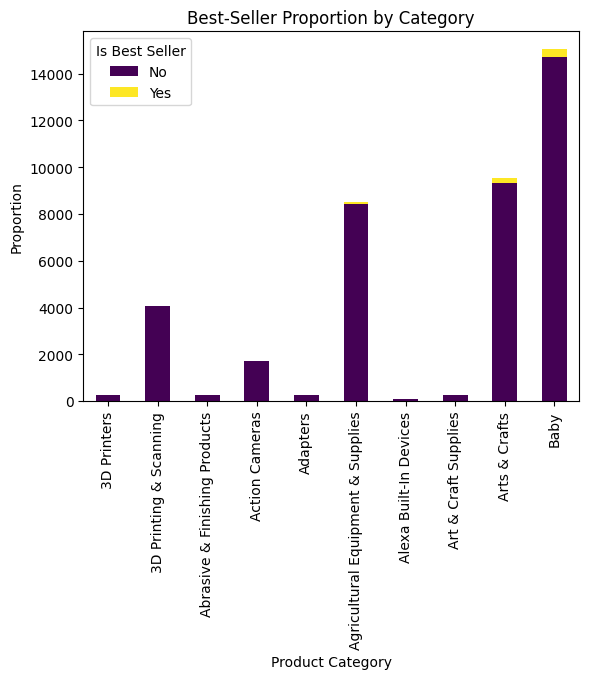

In [10]:
crosstab_result.head(10).plot(kind='bar', stacked=True, colormap='viridis')
plt.title("Best-Seller Proportion by Category")
plt.xlabel("Product Category")
plt.ylabel("Proportion")
plt.legend(title="Is Best Seller", labels=['No', 'Yes'])
plt.xticks(rotation=90)
plt.savefig(os.path.join(OUTPUT_DIR, f"besy_seller_by_category.png"), 
                bbox_inches='tight', 
                facecolor='none', 
                transparent=True)
plt.show()

# Part 2: Exploring Product Prices and Ratings Across Categories and Brands

### 0. Preliminary Step: Remove outliers in product prices

In [11]:
# Remove outliers using IQR method
products_copy = products.copy()
Q1 = products['price'].quantile(0.25)
Q3 = products['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
products_copy = products_copy[(products_copy['price'] >= lower_bound) & (products_copy['price'] <= upper_bound)]
products_copy.head(5)

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


In [12]:
ch.check(products_copy)

Number of columns: 9 and rows: 2115963

Data types:
uid                    int64
asin                  object
title                 object
stars                float64
reviews                int64
price                float64
isBestSeller            bool
boughtInLastMonth      int64
category              object
dtype: object

Unique values count:
uid                  2115963
asin                 1911040
title                1801141
stars                     42
reviews                19136
price                  10000
isBestSeller               2
boughtInLastMonth         25
category                 296
dtype: int64

These columns appear to be categorical (less than 20 unique values):
Index(['isBestSeller'], dtype='object')

Unique value count for categorical columns:

isBestSeller:
isBestSeller
False    2108246
True        7717
Name: count, dtype: int64

Count of null values:
uid                  0
asin                 0
title                0
stars                0
reviews            

### 1. Violin Plots:

#### Without outliers

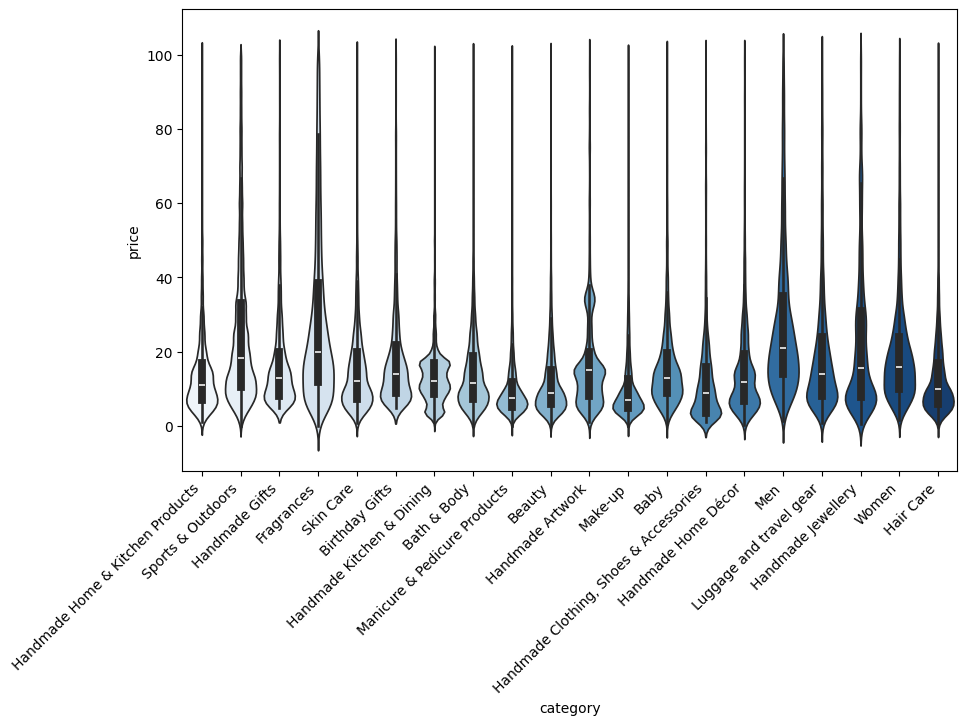

In [13]:
products_count =pd.crosstab(index=products_copy['category'], columns='count')
products_sorted = pd.DataFrame(products_count['count'].sort_values(ascending=False))
top_20_categories = products_sorted.head(20) 
top_products = products_copy[products_copy['category'].isin(top_20_categories.index)]

plt.figure(figsize=(10, 6))
sns.violinplot(x='category', 
                   y='price', 
                   data=top_products, 
                   hue='category', 
                   legend=False, 
                   density_norm='width',
                   palette="Blues")
plt.xticks(rotation=45, ha='right')

plt.savefig(os.path.join(OUTPUT_DIR, f"violin_plot_by_category_without.png"), 
                bbox_inches='tight', 
                facecolor='none', 
                transparent=True) 
plt.show()


In [14]:
category_median_price = products_copy.groupby('category')['price'].median()
category_median_price_sorted = category_median_price.sort_values(ascending=False)
highest_median_category = category_median_price_sorted.idxmax()
highest_median_price = category_median_price_sorted.max()
print(f"The product category with the highest median price is: {highest_median_category} with a median price of {highest_median_price}")

The product category with the highest median price is: Desktop PCs with a median price of 74.0


#### With outliers

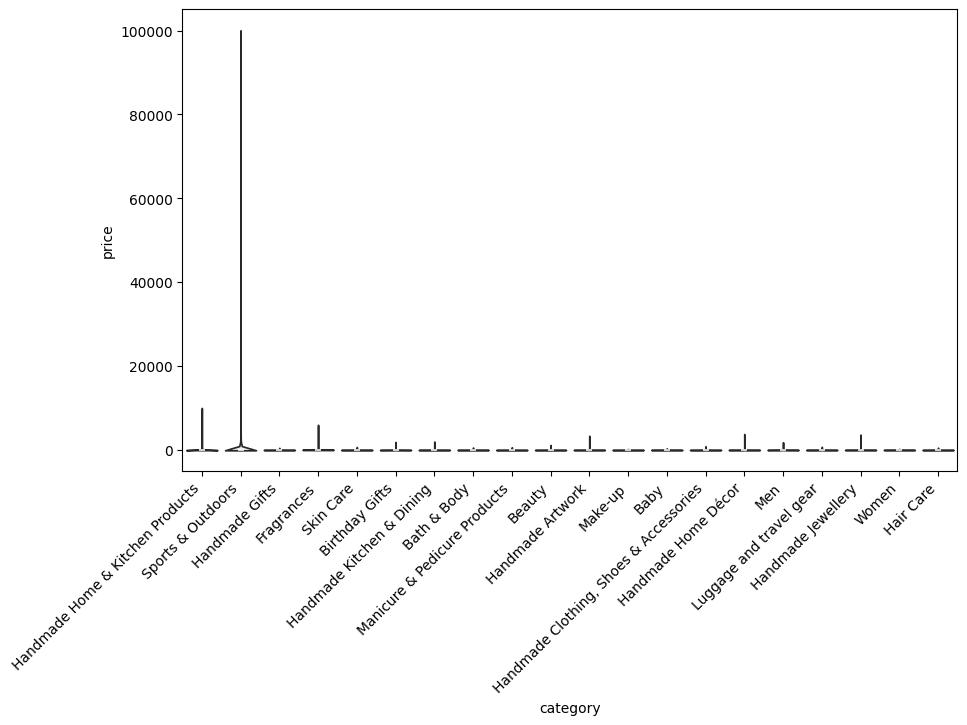

In [15]:
products_count_with =pd.crosstab(index=products['category'], columns='count')
products_sorted_with = pd.DataFrame(products_count_with['count'].sort_values(ascending=False))
top_20_categories_with = products_sorted_with.head(20) 
top_products_with = products[products['category'].isin(top_20_categories_with.index)]

plt.figure(figsize=(10, 6))
sns.violinplot(x='category', 
                   y='price', 
                   data=top_products_with, 
                   hue='category', 
                   legend=False, 
                   density_norm='width',
                   palette="Blues")
plt.xticks(rotation=45, ha='right')

plt.savefig(os.path.join(OUTPUT_DIR, f"violin_plot_by_category_with.png"), 
                bbox_inches='tight', 
                facecolor='none', 
                transparent=True) 
plt.show()

In [16]:
category_median_price_with = products.groupby('category')['price'].median()
category_median_price_sorted_with = category_median_price_with.sort_values(ascending=False)
highest_median_category_with = category_median_price_sorted_with.idxmax()
highest_median_price_with = category_median_price_sorted_with.max()
print(f"The product category with the highest median price is: {highest_median_category_with} with a median price of {highest_median_price_with}")

The product category with the highest median price is: Laptops with a median price of 1042.725


### 2. Bar Charts:

#### Without outliers

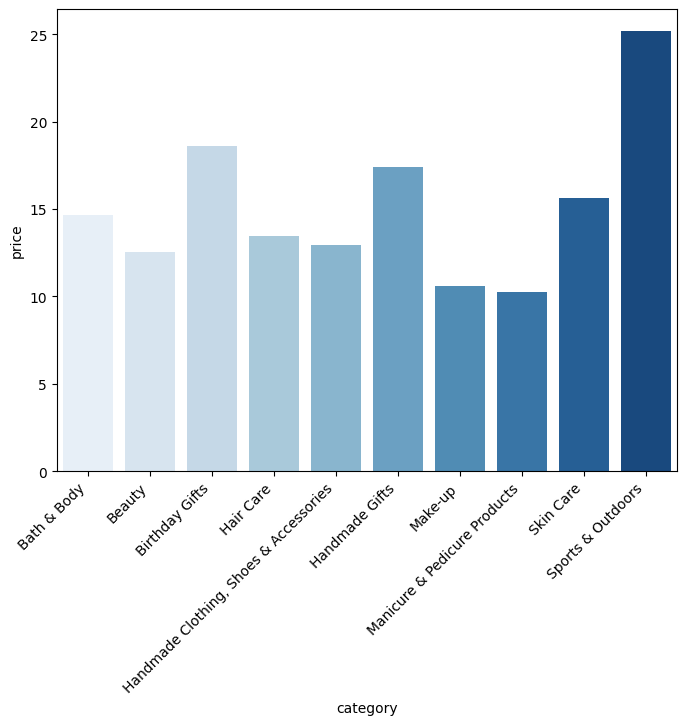

In [17]:
top_10_categories = products_sorted.head(10) 
category_mean_price = products_copy.groupby('category')['price'].mean().reset_index()

top_products_bar = category_mean_price[category_mean_price['category'].isin(top_10_categories.index)]

plt.figure(figsize=(8, 6))
sns.barplot(x=top_products_bar['category'], y=top_products_bar['price'], hue = top_products_bar['category'], palette="Blues")
plt.xticks(rotation=45, ha='right')

plt.savefig(os.path.join(OUTPUT_DIR, f"bar_chart_by_category_without.png"), 
                bbox_inches='tight', 
                facecolor='none', 
                transparent=True) 
plt.show()


In [18]:
category_mean_price

,category,price
0,3D Printers,55.739722
1,3D Printing & Scanning,35.623904
2,Abrasive & Finishing Products,14.427611
3,Action Cameras,38.936875
4,Adapters,8.750197
...,...,...
291,Wind Instruments,18.935339
292,Window Treatments,19.870633
293,Women,20.408735
294,Women's Sports & Outdoor Shoes,49.425894


In [19]:
category_mean_price_sorted = category_mean_price.sort_values(by='price',ascending=False)
highest_mean_category = category_mean_price_sorted['category'].max()
highest_mean_price = category_mean_price_sorted['price'].max()

print(f"The product category with the highest average price is: {highest_mean_category} with a average price of {highest_mean_price}")

The product category with the highest average price is: eBook Readers & Accessories with a average price of 68.77243243243242


#### With outliers

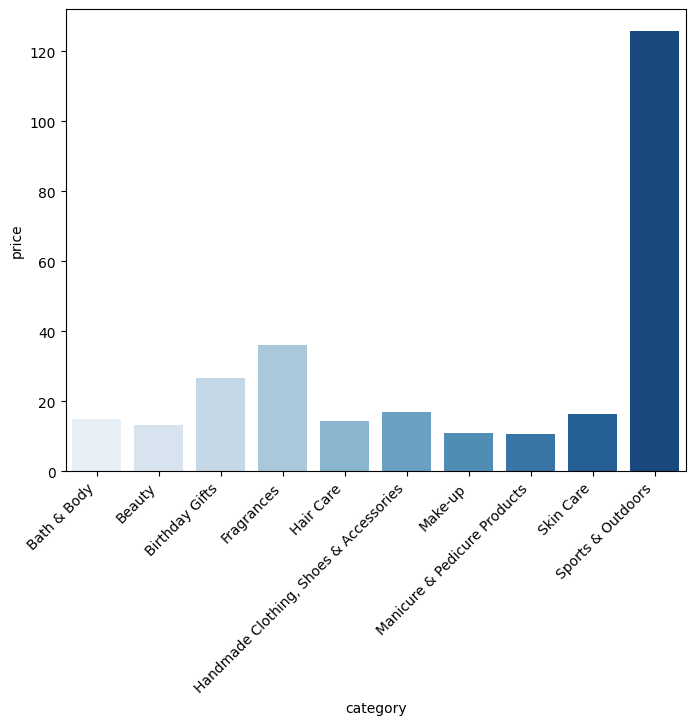

In [20]:
top_10_categories_with = products_sorted_with.head(10) 
category_mean_price_with = products.groupby('category')['price'].mean().reset_index()

top_products_bar_with = category_mean_price_with[category_mean_price_with['category'].isin(top_10_categories_with.index)]

plt.figure(figsize=(8, 6))
sns.barplot(x=top_products_bar_with['category'], y=top_products_bar_with['price'], hue = top_products_bar_with['category'], palette="Blues")
plt.xticks(rotation=45, ha='right')

plt.savefig(os.path.join(OUTPUT_DIR, f"bar_chart_by_category_with.png"), 
                bbox_inches='tight', 
                facecolor='none', 
                transparent=True) 
plt.show()


In [21]:
category_mean_price_sorted_with = category_mean_price_with.sort_values(by='price',ascending=False)
highest_mean_category_with = category_mean_price_sorted_with['category'].max()
highest_mean_price_with = category_mean_price_sorted_with['price'].max()

print(f"The product category with the highest average price is: {highest_mean_category_with} with a average price of {highest_mean_price_with}")

The product category with the highest average price is: eBook Readers & Accessories with a average price of 1087.987826986755


### 3. Box Plots:

#### Without outliers

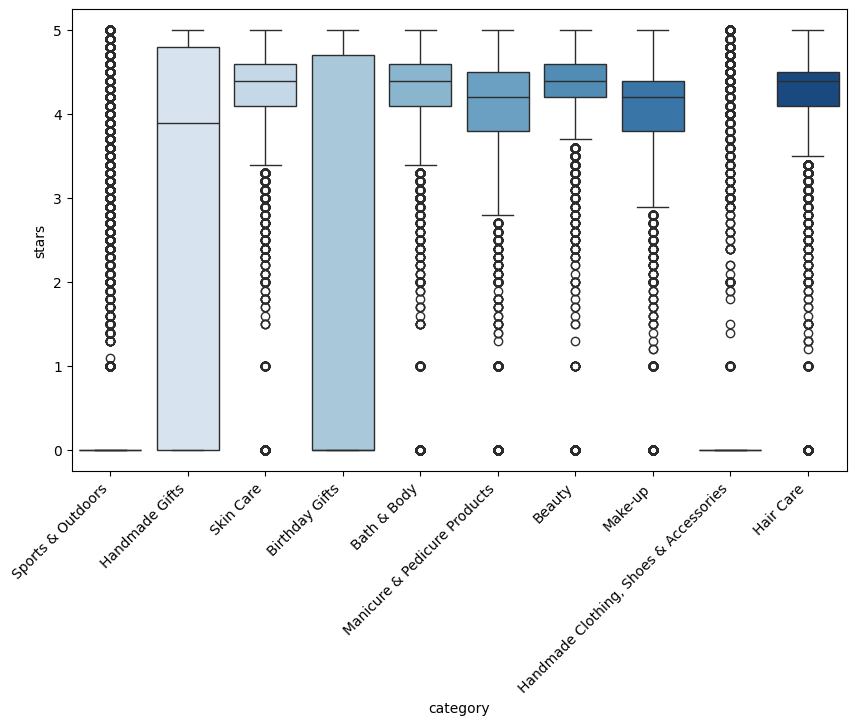

In [22]:
top_products_box = products_copy[products_copy['category'].isin(top_10_categories.index)]

plt.figure(figsize=(10, 6))
sns.boxplot (
        x='category', 
        y='stars', 
        hue='category', 
        data=top_products_box, 
        palette="Blues",
        )
plt.xticks(rotation=45, ha='right')

plt.savefig(os.path.join(OUTPUT_DIR, f"box_plot_by_category_without.png"), 
                bbox_inches='tight', 
                facecolor='none', 
                transparent=True)
plt.show() 


In [23]:
category_mean_raiting = products_copy.groupby('category')['stars'].median().reset_index()
category_mean_rating_sorted = category_mean_raiting.sort_values(by='stars',ascending=False)
highest_mean_category = category_mean_rating_sorted['category'].max()
highest_mean_price = category_mean_rating_sorted['stars'].max()

print(f"The product category with the highest median rating is: {highest_mean_category} with a median rating of {highest_mean_price}")

The product category with the highest median rating is: eBook Readers & Accessories with a median rating of 4.7


#### WIth outliers

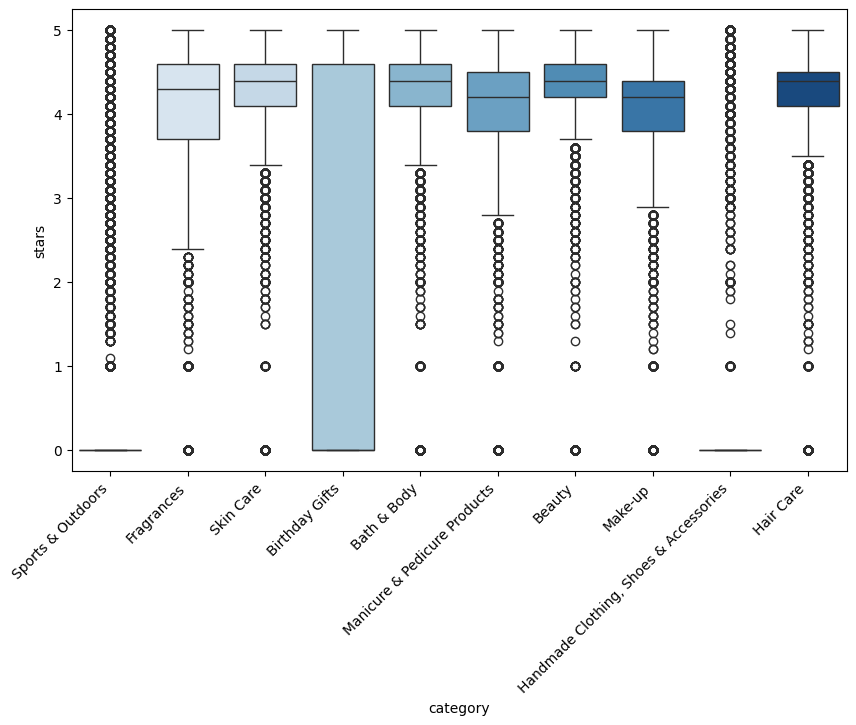

In [24]:
top_products_box_with = products[products['category'].isin(top_10_categories_with.index)]

plt.figure(figsize=(10, 6))
sns.boxplot (
        x='category', 
        y='stars', 
        hue='category', 
        data=top_products_box_with, 
        palette="Blues",
        )
plt.xticks(rotation=45, ha='right')

plt.savefig(os.path.join(OUTPUT_DIR, f"box_plot_by_category_with.png"), 
                bbox_inches='tight', 
                facecolor='none', 
                transparent=True) 
plt.show()

In [25]:
category_mean_raiting_with = products.groupby('category')['stars'].median().reset_index()
category_mean_rating_sorted_with = category_mean_raiting_with.sort_values(by='stars',ascending=False)
highest_mean_category_with = category_mean_rating_sorted_with['category'].max()
highest_mean_price_with = category_mean_rating_sorted_with['stars'].max()

print(f"The product category with the highest median rating is: {highest_mean_category_with} with a median rating of {highest_mean_price_with}")

The product category with the highest median rating is: eBook Readers & Accessories with a median rating of 4.7


# Part 3: Investigating the Interplay Between Product Prices and Ratings

### 1. Correlation Coefficients:

#### Without outliers

In [26]:
poearson_coeff = products_copy['price'].corr(products_copy['stars'])
spearman_coeff = products_copy['price'].corr(products_copy['stars'], method='spearman')

print (f"Pearson Correlation: {poearson_coeff} and Spearman Correlation {spearman_coeff}")
#There is not significant correlation

Pearson Correlation: -0.07767299878181323 and Spearman Correlation -0.06679697280768307


#### With outliers

In [27]:
poearson_coeff_with = products['price'].corr(products['stars'])
spearman_coeff_with = products['price'].corr(products['stars'], method='spearman')

print (f"Pearson Correlation: {poearson_coeff_with} and Spearman Correlation {spearman_coeff_with}")
#There is not significant correlation

Pearson Correlation: -0.12490673262148641 and Spearman Correlation -0.13316425462433912


### 2. Visualizations:

#### Without outliers

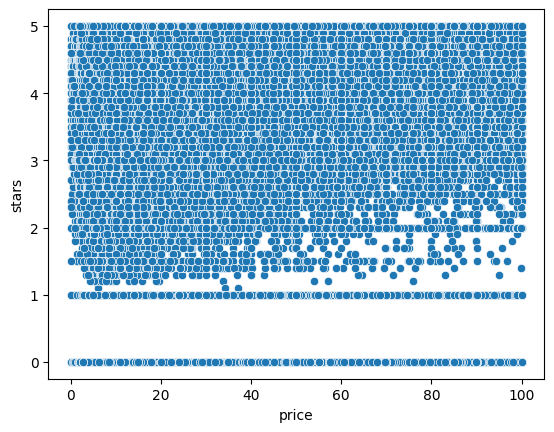

In [28]:
sns.scatterplot(data=products_copy, x='price', y='stars')

plt.savefig(os.path.join(OUTPUT_DIR, f"corr_sale_stars_without.png"), 
                bbox_inches='tight', 
                facecolor='none', 
                transparent=True) 
plt.show()


In [29]:
products_copy.head(5)

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


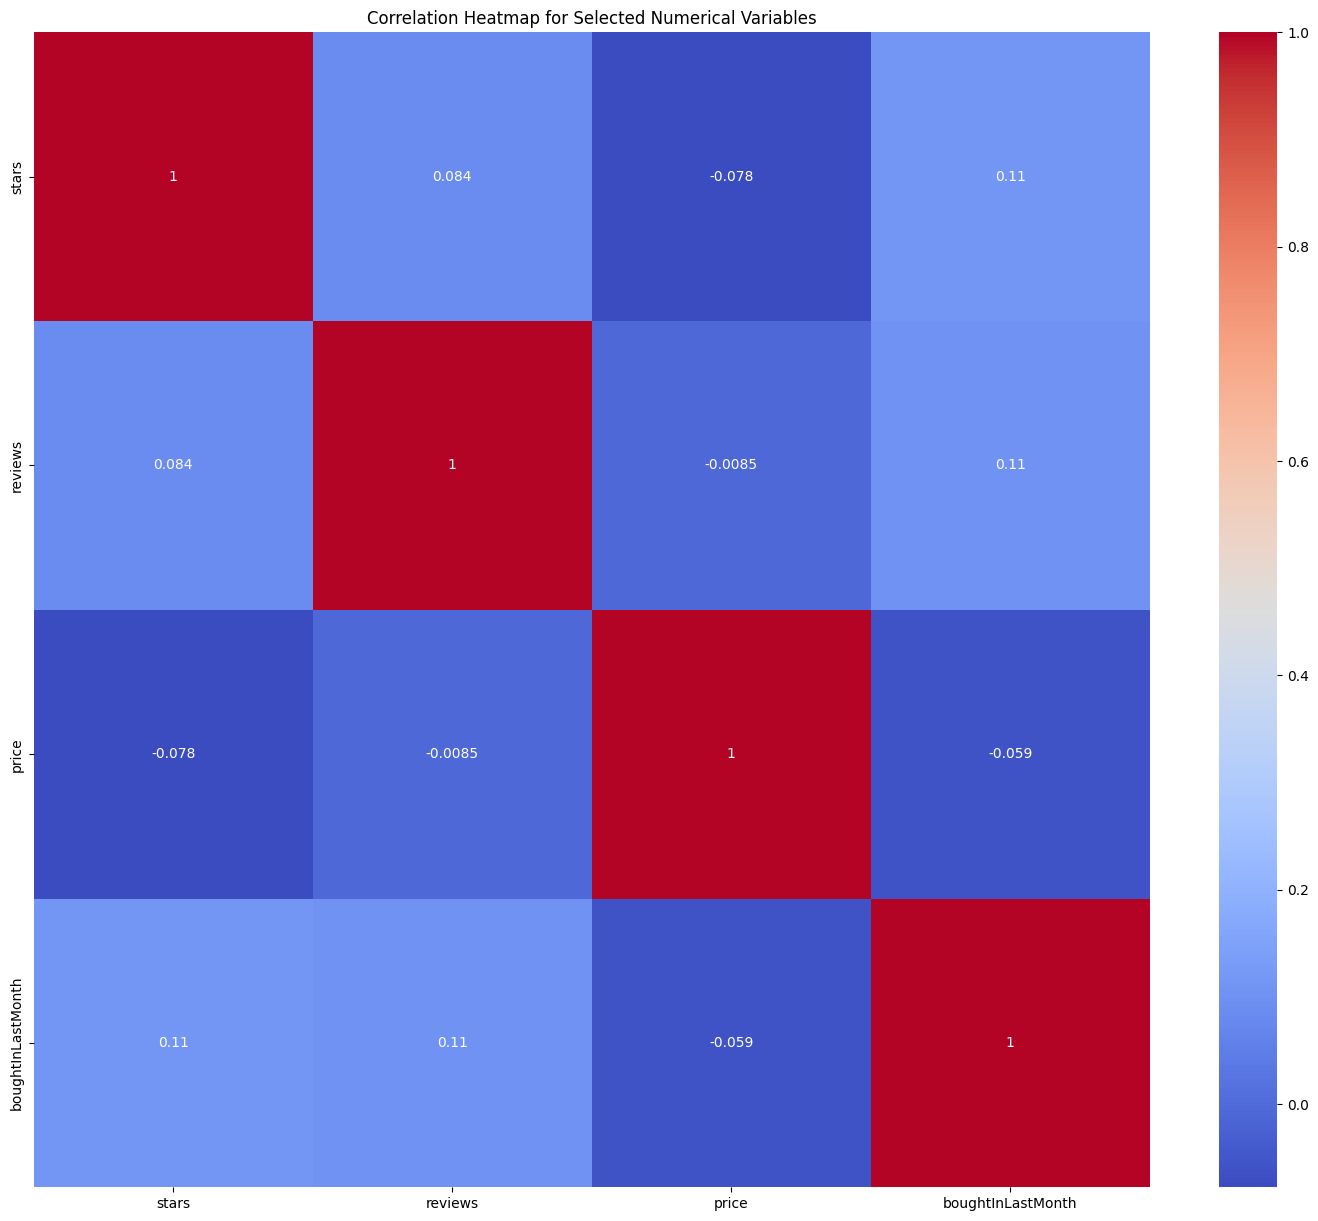

In [30]:
products_copy = products_copy.drop(columns=["uid", "asin"])
num = products_copy.select_dtypes(include="number")
cat_from_num = num.loc[:, num.nunique() < 20]
num = num.drop(columns=cat_from_num.columns)
correlation_matrix = num.corr()
plt.figure(figsize=(18, 15))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap for Selected Numerical Variables")

plt.savefig(os.path.join(OUTPUT_DIR, f"heatmap_without.png"), 
                bbox_inches='tight', 
                facecolor='none', 
                transparent=True) 
plt.show()

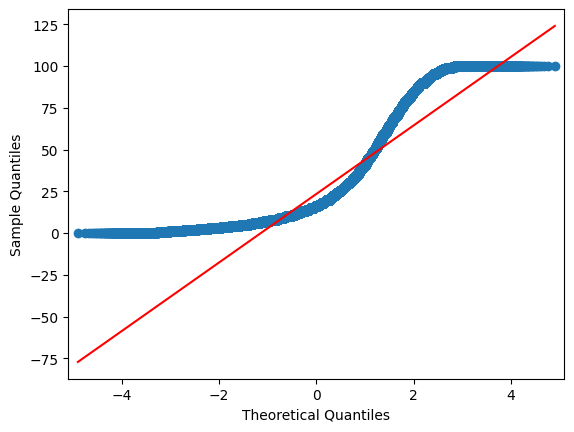

In [31]:
sm.qqplot(products_copy['price'], line='s')

plt.savefig(os.path.join(OUTPUT_DIR, f"qq_without.png"), 
                bbox_inches='tight', 
                facecolor='none', 
                transparent=True) 
plt.show()

#### With outliers

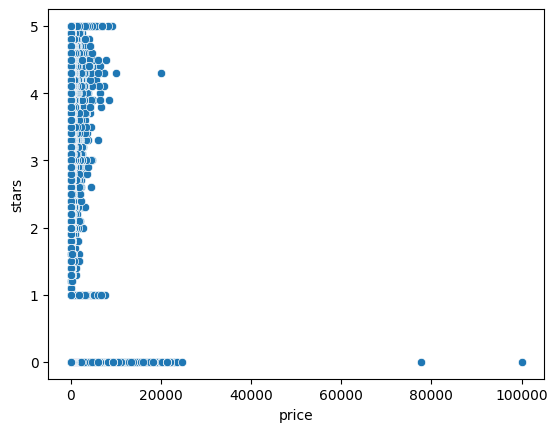

In [32]:
sns.scatterplot(data=products, x='price', y='stars')

plt.savefig(os.path.join(OUTPUT_DIR, f"corr_sale_stars_with.png"), 
                bbox_inches='tight', 
                facecolor='none', 
                transparent=True) 
plt.show()

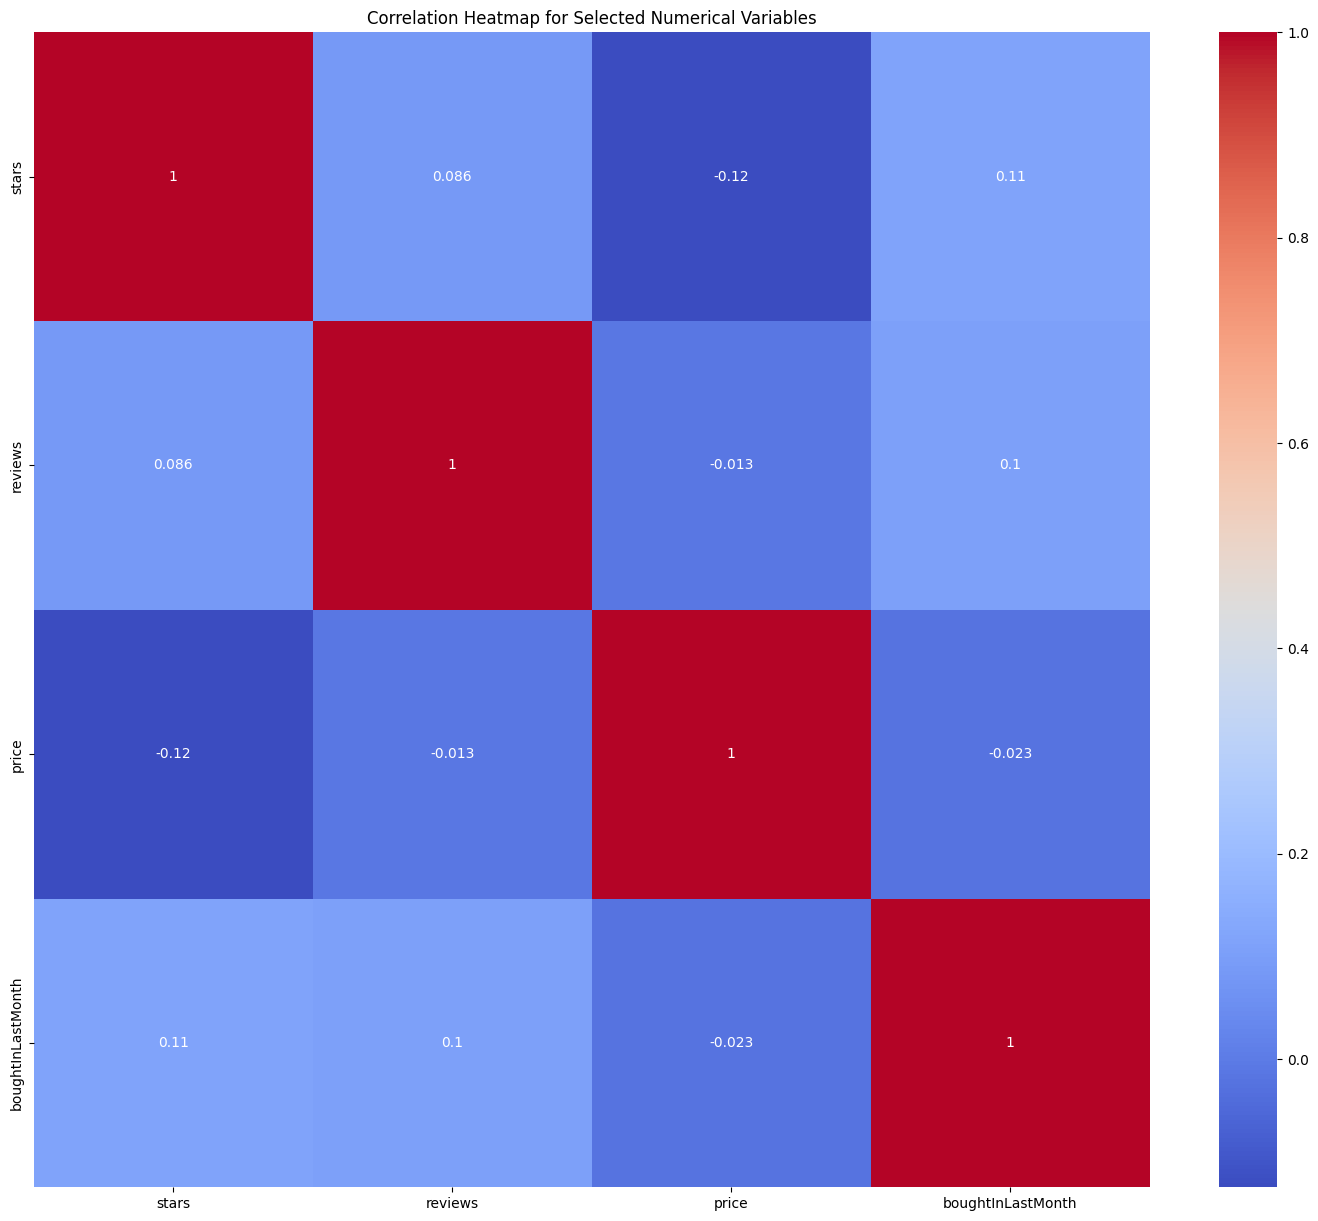

In [33]:
products = products.drop(columns=["uid", "asin"])
num_with = products.select_dtypes(include="number")
cat_from_num_with = num.loc[:, num.nunique() < 20]
num_with = num_with.drop(columns=cat_from_num_with.columns)
correlation_matrix_with = num_with.corr()
plt.figure(figsize=(18, 15))
sns.heatmap(correlation_matrix_with, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap for Selected Numerical Variables")

plt.savefig(os.path.join(OUTPUT_DIR, f"heatmap_with.png"), 
                bbox_inches='tight', 
                facecolor='none', 
                transparent=True) 
plt.show()

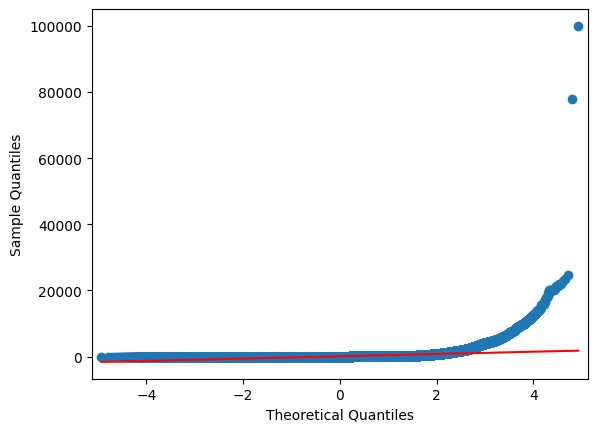

In [34]:
sm.qqplot(products['price'], line='s')

plt.savefig(os.path.join(OUTPUT_DIR, f"qq_with.png"), 
                bbox_inches='tight', 
                facecolor='none', 
                transparent=True) 
plt.show()